In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.fftpack
import random
import pandas as pd

In [0]:
class RandomProcessModel:
    def __init__(self, auto_corr, N=100, sigma=1, a=1, tau=0.1, data_size=100):
        self.N = N
        self.sigma= sigma
        self.a = a
        self.tau = tau
        self.data_size = data_size
        self.auto_corr = auto_corr
        
        self.x = np.arange(0, data_size, tau)
        self.white_noise = np.array([random.normalvariate(0, sigma) for _ in self. x])
        self.y = []
        
    
    def stupid_forming_filter(self, h_func):
        for i, val in enumerate(self.x):
            sum_y = 0
            for j in range(self.N):
                if j > i:
                    break
                    
                sum_y += self.white_noise[i - j] * h_func(j * self.tau, self.a, self.sigma)
                
            self.y.append(sum_y)
            
        self.y = np.array(self.y)
        
    def fast_forming_filter(self, h_func):
        preprocessed_h = np.array([h_func(i * self.tau, self.a, self.sigma) for i in range(self.N)])
        
        #consolve core is a fft with O(nlog(n))
        res = np.convolve(preprocessed_h, self.white_noise)
        
        self.y = res[:self.x.size]
    
    def recursive_filter(self, a, b):
        self.y.append(self.white_noise[0])
        
        for i, val in enumerate(self.x):
            self.y.append(self.white_noise[i] * a(self.a, self.tau) + self.y[-1] * b(self.a, self.tau))
            
        self.y = np.array(self.y[1:])
    
    def eval_params(self):
        params = {'Params': ['Expectation', 'Varience'],
                  'Random Process': [self.y.mean(), self.y.std()]}
        return pd.DataFrame(params)
    
    def estimated_autocorrelation(self):
        n = len(self.y)
        variance = self.y.var()
        x = self.y - self.y.mean()
        r = np.correlate(x, x, mode = 'full')[-n:]
        result = r / (variance * (np.arange(n, 0, -1)))
        return result
    
    def estimated_spectr(self, y):
        yf = scipy.fftpack.fft(y)
        N = y.size
        return np.linspace(0.0, 1.0/(2.0*self.tau), N/2), np.abs(yf[:N//2])
    
    def plot_results(self):
        f = plt.figure(figsize=(20,10))
        ax = f.add_subplot(221)
        plt.title("White noise")
        plt.xlabel('Time')
        plt.xlabel('Value')
        ax.plot(self.x, self.white_noise)
        
                
        ax2 = f.add_subplot(222)
        plt.title("Random process")
        plt.xlabel('Time')
        plt.ylabel('Value')
        ax2.plot(self.x, self.y)
        
                
        ax3 = f.add_subplot(223)
        plt.title("Autocorrelation")
        plt.xlabel('Time')
        plt.ylabel('Value')
        autocorrelation = self.estimated_autocorrelation()
        plt1 = plt.plot(self.x[:50], autocorrelation[:50])
        plt2 = plt.plot(self.x[:50], self.auto_corr(self.x, self.a, self.sigma)[:50])
        plt.legend((plt1[0], plt2[0]), ('Model', 'Teor'))
        
        ax4 = f.add_subplot(224)
        plt.title("Spectral density")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt1 =plt.plot(*self.estimated_spectr(autocorrelation[:50]))
        plt2 = plt.plot(*self.estimated_spectr(self.auto_corr(self.x, self.a, self.sigma))[:50])
        plt.legend((plt1[0], plt2[0]), ('Model', 'Teor'))

## 1 вариант

In [0]:
def h_func(x, a, sigma):
    K = sigma * np.sqrt(1 / (np.pi * a))
    result = K * a * np.exp(-a * x)
    return result

In [0]:
def auto_corr(x, a, sigma):
    return sigma** 2 * np.exp(-a*np.abs(x))

O(n^2)

In [0]:
model = RandomProcessModel(data_size=1000, auto_corr=auto_corr, a=2)
%time model.stupid_forming_filter(h_func)
model.eval_params()

CPU times: user 2.95 s, sys: 998 µs, total: 2.95 s
Wall time: 2.95 s


Params  Random Process
0  Expectation        0.031455
1     Varience        1.378473

O(nlog(n))

In [0]:
model = RandomProcessModel(data_size=10, auto_corr=auto_corr, a=2)
%time model.fast_forming_filter(h_func)
model.eval_params()

CPU times: user 321 µs, sys: 158 µs, total: 479 µs
Wall time: 410 µs


Params  Random Process
0  Expectation       -0.607987
1     Varience        1.094549

O(n) (Recurrent method)

In [0]:
def a(a, tau):
    p = np.exp(-1 * a * tau)
    return np.sqrt(1 - p ** 2)

def b(a, tau):
    return np.exp(-1 * a * tau)

In [1]:
model = RandomProcessModel(data_size=10000, auto_corr=auto_corr, a=2)
%time  model.recursive_filter(a, b)
model.eval_params()

NameError: ignored

/home/eugene/.virtualenvs/pubg/lib/python3.5/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


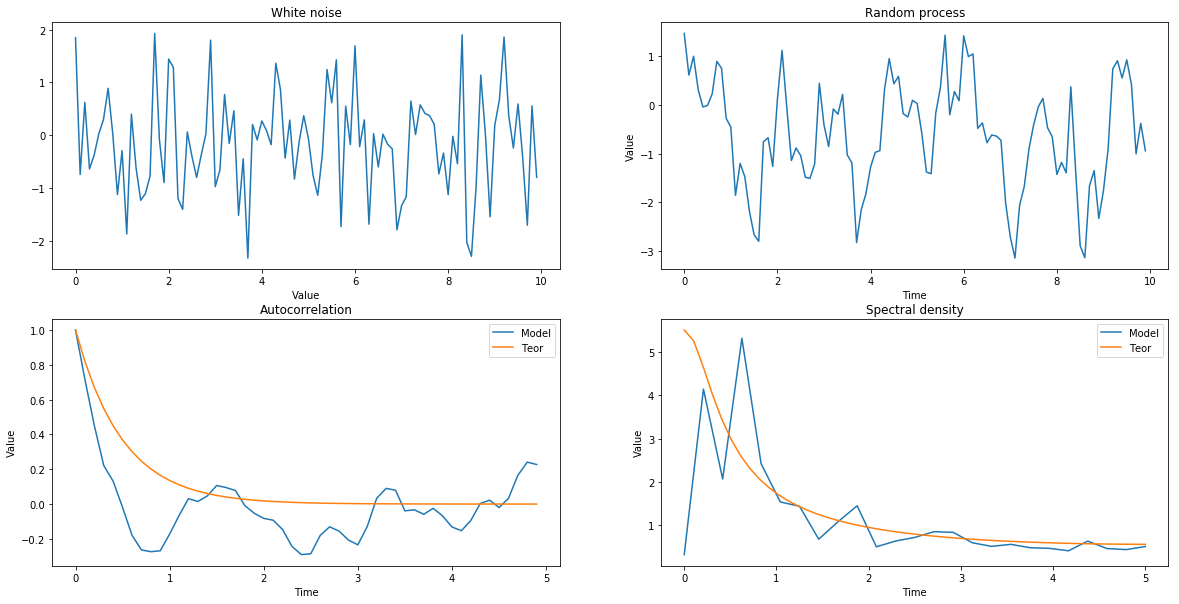

In [0]:
model.plot_results()

## 2 вариант

In [0]:
def h_func(x, a, sigma):
    K = sigma * np.sqrt(2 / (np.pi * a))
    result = K * a * a * x * np.exp(-a * x)
    return result

In [0]:
def auto_corr(x, a, sigma):
    return sigma** 2 * np.exp(-a*np.abs(x)) * (1 + a * np.abs(x))

In [0]:
model = RandomProcessModel(data_size=1000, auto_corr=auto_corr)
model.fast_forming_filter(h_func)
model.eval_params()

Params  Random Process
0  Expectation        0.033147
1     Varience        1.287727

In [0]:
model.plot_results()

/home/eugene/.virtualenvs/pubg/lib/python3.5/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


##  3 Вариант

In [0]:
def h_func(x, a, sigma):
    K = sigma * np.sqrt(2 / (3 * (np.pi * a)))
    result = K * a ** 3 * x ** 2 * np.exp(-a * x)
    return result

In [0]:
def auto_corr(x, a, sigma):
    return sigma ** 2 * np.exp(-1*np.abs(x)) * (1 + a * np.abs(x) + a ** 2 * x ** 2 / 3)

In [0]:
model = RandomProcessModel(data_size=1000, auto_corr=auto_corr)
model.fast_forming_filter(h_func)
model.eval_params()

Params  Random Process
0  Expectation        0.050988
1     Varience        1.335987

/home/eugene/.virtualenvs/pubg/lib/python3.5/site-packages/ipykernel_launcher.py:60: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


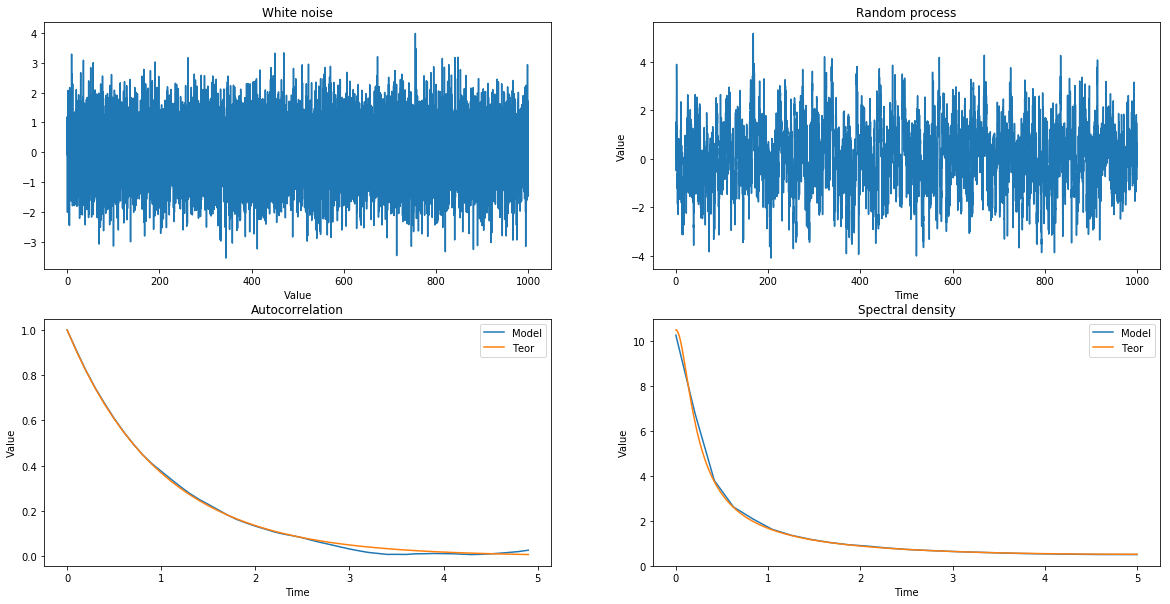

In [0]:
model.plot_results()

In [0]:
plt.plot(range(10))